In [22]:
import numpy as np
import networkx as nx
import tqdm as tqdm
from collections import defaultdict
from kappa_tools import *
from ktools import *
import sklearn as sk
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import dill 
dill.load_session("notebook_env.db")
import igraph as ig
import leidenalg

In [23]:
def tranlsate_communities(cm:list[set]):
    community_lva = []
    node_lva = []

    for i,set in enumerate(cm):
        for n in list(set):
            node_lva.append(n)
            community_lva.append(i)

    gen_labels_lva = pd.DataFrame({"node": node_lva, "community":community_lva})
    gen_labels_lva = gen_labels_lva.sort_values(by="node")
    #gen_labels_lva = gen_labels_lva[gen_labels_lva["node"]!=0]

    return gen_labels_lva


def assign_to_mat(A, ground,pred,c):
    """ # assigns l`_ij =  AivBj - Ai^Bj if i <= c (minus 1 is for python indexing reasons) """    
    m = A.shape[0]
    for i,j in np.ndindex(m, m): 
        if i <= (c -1):
            A[i,j] = np.sum(np.logical_or(ground == i , pred == j )) - np.sum(np.logical_and(ground==i, pred==j))

    return A

np.vectorize(assign_to_mat)

def create_cost_matrix(ground: np.array, pred:np.array):
    """Creates a cost matrix for the assignment problem (source evaluating community detection algorithms)"""
    u = (len(np.unique(ground)), len(np.unique(pred))) # gets the ammount of communities

    c_star = max(u) 
    c = min(u)

    A = np.zeros((c_star, c_star))
    A = assign_to_mat(A, ground, pred, c)

    return A    


def remap_communities(ground:np.array, pred:np.array):
    """Remaps communities from the predictions to the correspondent ground communities using a cost matrix and the Munkres algorithm"""
    
    cost_mat = create_cost_matrix(ground,pred)
    
    # ------------------------ caculates munkres algorithm ----------------------- #
    mun = Munkres()
    indexes = mun.compute(cost_mat)

    # ---------------------------------- mapping --------------------------------- #
    index_dict = {i:j for i, j in indexes} #new map

    pred = pd.Series(pred) # to use series.map
    pred = pred.map(index_dict)

    return pred


def calculate_kappa(ground, pred):
    """Calculates the kappa index for a set of predictions and ground truths"""

    accuracy = accuracy_score(ground, pred)
    expected_accuracy = 1/(len(ground.unique()))


    kappa_index = (accuracy - expected_accuracy)/(1-expected_accuracy)
    return kappa_index


def kappa(ground:np.array, pred:np.array):
    """" Calculates the kappa index for a given set of groudn truth communities and a set of labels

    Args:
        ground (np.array): ground communities
        pred (np.array): labels

    Returns:
        float: kappa index 
    """    

    accuracy = accuracy_score(ground, pred)
    expected_accuracy = 1/(len(ground.unique()))

    kappa_index = (accuracy - expected_accuracy)/(1-expected_accuracy)
    return kappa_index

In [24]:
# matrix to numpy
def to_np(G:nx.multidigraph):
    edges = list(G.edges())#gets edges from generated network
    l = []
    [(l.append(x[0]), l.append(x[1])) for x in edges] #shape of matrix 
    m = max(l) +1
    A = np.zeros([m,m])

    for e in edges:
        A[e[0], e[1]] = 1


    return A

In [25]:
# Inducing flow
def flow_ij(G,i,j):
    return nx.flow.maximum_flow(G, i, j)[0]

def create_id(A):
    G = nx.from_numpy_array(A, parallel_edges=True,create_using=nx.DiGraph, edge_attr="capacity")
    m = A.shape[0]
    ind_i = ind_j = np.arange(0,m)
    Id = np.zeros([m,m])

    return Id


In [26]:
from networkx.generators.community import LFR_benchmark_graph
n = 250
tau1 = 3
tau2 = 1.5
mu = 0.5
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=5, min_community=20
)

KeyboardInterrupt: 

In [ ]:
A = to_np(G)
D = nx.from_numpy_array(A, parallel_edges=True,create_using=nx.DiGraph, edge_attr="capacity")
I = np.zeros((A.shape[0], A.shape[0]))

for i in tqdm.tqdm(range(A.shape[0])):
    for j in range(A.shape[0]):
        if i != j:
            I[i,j] = flow_ij(D, i,j)
        else:
            I[i,j] = 0

  1%|          | 3/250 [00:02<03:57,  1.04it/s]


KeyboardInterrupt: 

In [ ]:
# Creating Baseline Louvain

baseline_communities_average_mod = np.average(nx.community.modularity(G,nx.community.louvain_communities(G)))
baseline_communities = nx.community.louvain_communities(G)
baseline_communities_average_mod

0.4445125

In [ ]:
# Traingin FCL

# Generating Networks

networks = []
for i in tqdm.tqdm(range(10)):
    n =  50
    tau1 = 2.5
    tau2 = 1.5
    mu = 0.1
    G = LFR_benchmark_graph(
        n, tau1, tau2, mu, max_degree=10, average_degree=4, min_community=7, max_community=10,
    )
    networks.append(G)


networks

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 416.47it/s]


In [ ]:
flow_networks =[]

for net in networks:
    A = to_np(net)
    D = nx.from_numpy_array(A, parallel_edges=True,create_using=nx.DiGraph, edge_attr="capacity")
    I = np.zeros((A.shape[0], A.shape[0]))
    
    for i in tqdm.tqdm(range(A.shape[0])):
        for j in range(A.shape[0]):
            if i != j:
                I[i,j] = flow_ij(D, i,j)
            else:
                I[i,j] = 0
    flow_networks.append(I)

100%|██████████| 50/50 [00:00<00:00, 51.02it/s]


In [ ]:
flow_networks = [i/np.sum(i) for i in flow_networks]

In [ ]:
net_adj = [nx.to_numpy_array(i) for i in networks]

In [ ]:
# fitting process

mod_dict = defaultdict(list)
for alpha in tqdm.tqdm(np.arange(0,1,0.1)):
    modularities = []
    for ind,I in enumerate(flow_networks):
        F = alpha*I + (1-alpha)*net_adj[ind]
        F = nx.from_numpy_array(F)
        ic  = nx.community.louvain_communities(F)
        mod_ic = nx.community.modularity(F,ic)
        mod_dict[alpha].append(mod_ic)




100%|██████████| 10/10 [00:00<00:00, 33.64it/s]


In [ ]:
averages = [np.average(values) for  values in mod_dict.values()]
list(mod_dict.keys())[averages.index(max(averages))]
averages

[0.7541558995828054,
 0.753197027547184,
 0.7530710587807348,
 0.7519692833668375,
 0.7525228773489518,
 0.7520848615522299,
 0.751480358706208,
 0.7504278192822593,
 0.7483415101379699,
 0.7411872444876808]

In [ ]:
A = to_np(G)
D = nx.from_numpy_array(A, parallel_edges=True,create_using=nx.DiGraph, edge_attr="capacity")
I = np.zeros((A.shape[0], A.shape[0]))

for i in tqdm.tqdm(range(A.shape[0])):
    for j in range(A.shape[0]):
        if i != j:
            I[i,j] = flow_ij(D, i,j)
        else:
            I[i,j] = 0


100%|██████████| 50/50 [00:00<00:00, 51.06it/s]


In [ ]:
F = 0.1*I + (1-0.1)*A
F = nx.from_numpy_array(F)

In [ ]:
baseline_communities_average_mod = np.average([nx.community.modularity(G,nx.community.louvain_communities(G)) for _ in range(10)])
baseline_communities_var = np.var([nx.community.modularity(G,nx.community.louvain_communities(G)) for _ in range(10)])
preprocessed_communities_average_mod = np.average([nx.community.modularity(G,nx.community.louvain_communities(F))for _ in range(10)])
#baseline_communities_average_mod, preprocessed_communities_average_mod, nx.community.modularity(G)

In [ ]:
preprocessed_communities = nx.community.louvain_communities(F)
baseline_communities = nx.community.louvain_communities(G)

In [ ]:
ground_communities = {frozenset(G.nodes[v]["community"]) for v in G}
ground_communities_labels = [[i]*len(j) for i,j in enumerate([list(x) for x in ground_communities])]
ground_communities_labels = [i for ls in ground_communities_labels for i in ls]
baseline_communities_labels = [[i]*len(j) for i,j in enumerate([list(x) for x in baseline_communities])]
baseline_communities_labels = [ i for ls in baseline_communities_labels for i in ls]
preprocessed_communities_labels = [[i]*len(j) for i,j in enumerate([list(x) for x in preprocessed_communities])]
preprocessed_communities_labels = [ i for ls in preprocessed_communities_labels for i in ls]

In [ ]:
nmi_baseline = sk.metrics.cluster.normalized_mutual_info_score(ground_communities_labels, baseline_communities_labels)
nmi_preprocessed = sk.metrics.cluster.normalized_mutual_info_score(ground_communities_labels, preprocessed_communities_labels)
nmi_baseline, nmi_preprocessed


(0.7924706306518426, 0.8263478972349744)

In [ ]:
remap_baseline= remap_communities(ground_communities_labels, baseline_communities_labels)
remap_preprocessed = remap_communities( ground_communities_labels, preprocessed_communities_labels)

In [ ]:
calculate_kappa(pd.Series(ground_communities_labels), pd.Series(remap_baseline)), calculate_kappa(pd.Series(ground_communities_labels), pd.Series(remap_preprocessed))

(0.7839999999999999, 0.8079999999999999)

In [ ]:
def create_cost_matrix(ground: np.array, pred:np.array):
    """Creates a cost matrix for the assignment problem (source evaluating community detection algorithms)"""
    u = (len(np.unique(ground)), len(np.unique(pred))) # gets the ammount of communities
    c_star = max(u) 
    c = min(u)
    A = np.zeros((c_star, c_star))
    m = c_star

    for i,j in np.ndindex(m, m): 
        if i <= c:
            A[i,j] = np.sum(np.logical_or(ground == i , pred == j )) - np.sum(np.logical_and(ground==i, pred==j))

    # ------------------------ caculates munkres algorithm ----------------------- #
    mun = Munkres()
    indexes = mun.compute(A)

    # ---------------------------------- mapping --------------------------------- #
    index_dict = {i:j for i, j in indexes} #new map

    pred = pd.Series(pred) # to use series.map
    pred = pred.map(index_dict)

    return A, pred

In [ ]:
ground_communities = {frozenset(G.nodes[v]["community"]) for v in G}
ground_communities_labels = [[i]*len(j) for i,j in enumerate([list(x) for x in ground_communities])]
ground_communities_labels = [i for ls in ground_communities_labels for i in ls]
baseline_communities_labels = [[i]*len(j) for i,j in enumerate([list(x) for x in baseline_communities])]
baseline_communities_labels = [ i for ls in baseline_communities_labels for i in ls]
preprocessed_communities_labels = [[i]*len(j) for i,j in enumerate([list(x) for x in preprocessed_communities])]
preprocessed_communities_labels = [ i for ls in preprocessed_communities_labels for i in ls]

In [ ]:
ground_communities_labels, preprocessed_communities_labels, baseline_communities_labels = np.array(ground_communities_labels), np.array(preprocessed_communities_labels),np.array(baseline_communities_labels)

cost_mat, mapped = create_cost_matrix(ground_communities_labels, preprocessed_communities_labels)
cost_mat, mapped_base = create_cost_matrix(ground_communities_labels, baseline_communities_labels)

In [ ]:
calculate_kappa(pd.Series(ground_communities_labels),pd.Series(mapped_base)), sk.metrics.cluster.normalized_mutual_info_score(ground_communities_labels, mapped_base),calculate_kappa(pd.Series(ground_communities_labels),pd.Series(mapped)),sk.metrics.cluster.normalized_mutual_info_score(ground_communities_labels, mapped)



(0.7839999999999999,
 0.7924706306518426,
 0.8079999999999999,
 0.8263478972349744)

In [ ]:
G = G.to_directed()

In [ ]:
a = [frozenset(G.nodes[v]['community']) for v in G]


color_dict = {}

for node in a:
    if node not in color_dict:
        color_dict[node] = 0

for i,key in enumerate(color_dict.keys()):
    color_dict[key] = plt.colormaps["tab20"](i)


node_colors = [color_dict[frozenset(G.nodes[node]['community'])] for node in G.nodes]
node_colors_baseline = preprocessed_communities_labels

Text(0.5, 1.0, 'Sample Ground Communities')

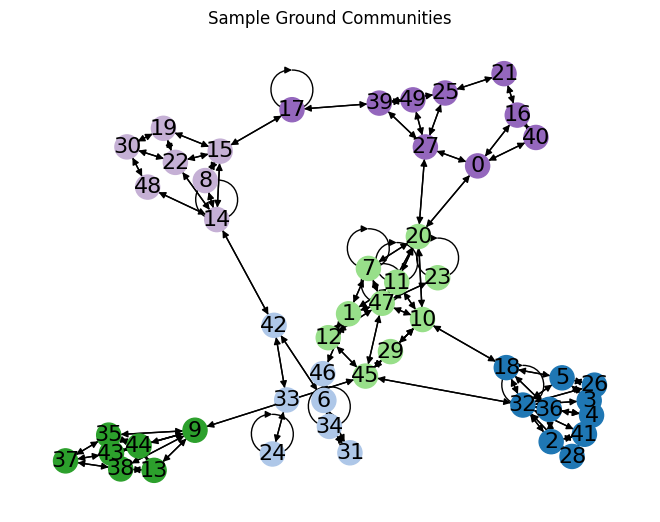

In [ ]:
edge_attrs = {}
for i in range(I.shape[0]):
    for j in range(I.shape[0]):
        if j in G[i]:
            x = I[i][j]
            edge_attrs[(i,j)] = {"weigth": 1+x}

nx.set_edge_attributes(G, edge_attrs)

edge_widths = [edge_attrs[key]["weigth"] for key in edge_attrs.keys()]

#[G[u][v]["capacity"] for u,v in G.edges()] > 0
nx.draw(G, with_labels=True, node_color=node_colors, node_size=300, font_size=16, width=edge_widths, arrows=True)

plt.title("Sample Ground Communities")

In [ ]:
def node_to_com(G, communities):
    node_dict = {}
    for node in G.nodes:
        for comm in communities:
            if node in comm:
                node_dict[node] = comm

    return node_dict

Text(0.5, 1.0, 'Sample Baseline Louvain')

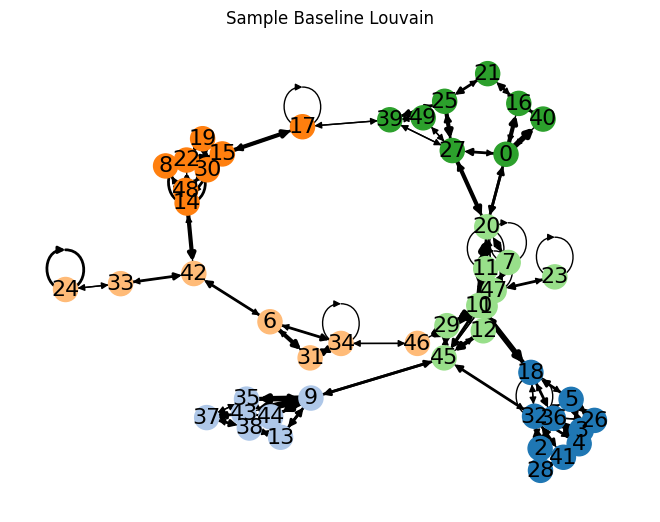

In [ ]:

#nx.draw(G, with_labels=True, node_color=mapped_base, node_size=300, font_size=16, width=edge_widths, arrows=True)

a = [frozenset(c) for c in baseline_communities]

baseline_communities
color_dict = {}

edge_attrs = {}
for i in range(I.shape[0]):
    for j in range(I.shape[0]):
        if j in G[i]:
            x = I[i][j]
            edge_attrs[(i,j)] = {"weigth": 1+x }

edge_widths = [edge_attrs[key]["weigth"] for key in edge_attrs.keys()]

for node in a:
    if node not in color_dict:
        color_dict[node] = 0

for i,key in enumerate(color_dict.keys()):
    color_dict[key] = plt.colormaps["tab20"](i)
    
nx.set_edge_attributes(G, edge_attrs)

n2c_baseline = node_to_com(G, baseline_communities)

node_colors = [color_dict[frozenset(community)] for node, community in n2c_baseline.items()]
node_colors_baseline = preprocessed_communities_labels


edge_widths = [edge_attrs[key]["weigth"] for key in edge_attrs.keys()]


nx.draw(G, with_labels=True, node_color=node_colors, node_size=300, font_size=16, width=edge_widths, arrows=True)

plt.title("Sample Baseline Louvain")

Text(0.5, 1.0, 'Sample Preprocessed Louvain')

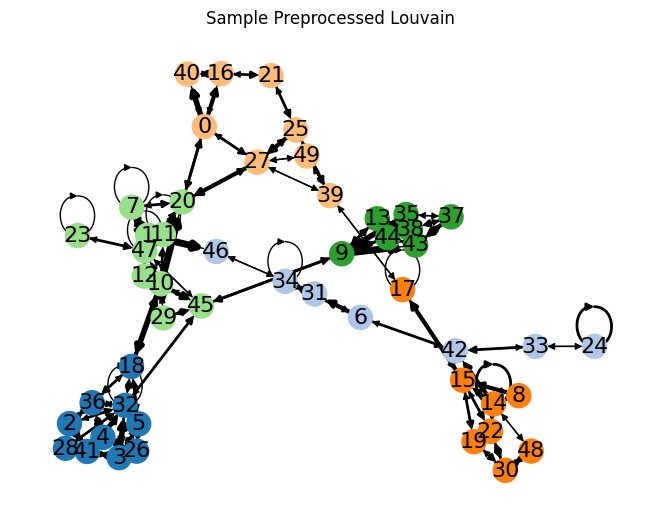

In [ ]:

a = [frozenset(c) for c in preprocessed_communities]

baseline_communities
color_dict = {}

for node in a:
    if node not in color_dict:
        color_dict[node] = 0

for i,key in enumerate(color_dict.keys()):
    color_dict[key] = plt.colormaps["tab20"](i)
    
nx.set_edge_attributes(G, edge_attrs)

n2c_preprocessed = node_to_com(G, baseline_communities)

node_colors = [color_dict[frozenset(community)] for node, community in n2c_preprocessed.items()]
node_colors_baseline = preprocessed_communities_labels


edge_widths = [edge_attrs[key]["weigth"] for key in edge_attrs.keys()]


nx.draw(G, with_labels=True, node_color=node_colors, node_size=300, font_size=16, width=edge_widths, arrows=True)

plt.title("Sample Preprocessed Louvain")

In [ ]:
nx.community.girvan_newman(G)
comp = nx.community.girvan_newman(G)
gn = tuple(sorted(c) for c in next(comp))



In [ ]:
gn_labels = [[i]*len(j) for i,j in enumerate([list(x) for x in gn])]
gn_labels = [ i for ls in preprocessed_communities_labels for i in gn_labels]

Text(0.5, 1.0, 'Sample Girvan-Newman')

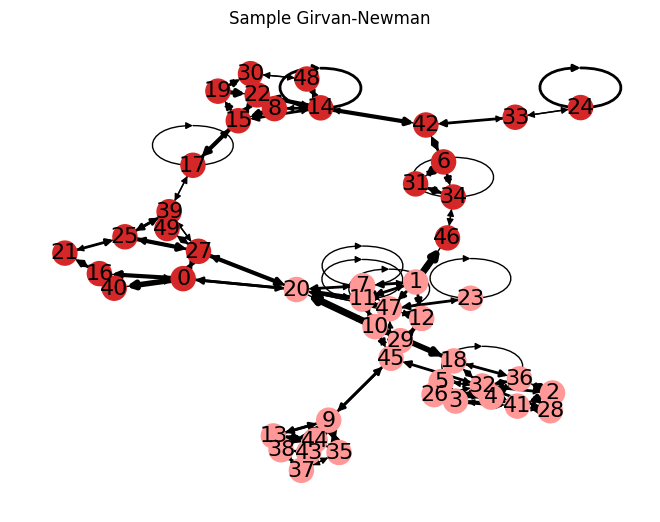

In [ ]:
a = [frozenset(c) for c in gn]

for node in a:
    if node not in color_dict:
        color_dict[node] = 0

for i,key in enumerate(color_dict.keys()):
    color_dict[key] = plt.colormaps["tab20"](i)



edge_widths = [edge_attrs[key]["weigth"] for key in edge_attrs.keys()]

n2c_baseline = node_to_com(G, gn)

node_colors = [color_dict[frozenset(community)] for node, community in n2c_baseline.items()]
node_colors_baseline = preprocessed_communities_labels

nx.draw(G, with_labels=True, node_color=node_colors, node_size=300, font_size=16, width=edge_widths, arrows=True)

plt.title("Sample Girvan-Newman")


In [ ]:
nx.community.girvan_newman(G)
comp = nx.community.girvan_newman(G)
gn = tuple(sorted(c) for c in next(comp))

gn_communities = {frozenset(c) for c in gn}
gn_communities_labels = [[i]*len(j) for i,j in enumerate([list(x) for x in gn_communities])]
gn_communities_labels = [i for ls in gn_communities_labels for i in ls]
gn_communities_labels = np.array(gn_communities_labels)

cost_mat, mapped_gn = create_cost_matrix(ground_communities_labels, gn_communities_labels)

In [ ]:
calculate_kappa(pd.Series(mapped_gn),pd.Series(ground_communities_labels)) , sk.metrics.cluster.normalized_mutual_info_score(mapped_gn, ground_communities_labels)

(-0.24, 0.5590776470074131)

In [ ]:
mod_dict = defaultdict(list)
for alpha in tqdm.tqdm(np.arange(0,1,0.1)):
    modularities = []
    for ind,I in enumerate(flow_networks):
        F = alpha*I + (1-alpha)*net_adj[ind]
        F = nx.from_numpy_array(F)
        comp = nx.community.girvan_newman(F)
        ic = tuple(sorted(c) for c in next(comp))
        mod_ic = nx.community.modularity(F,ic)
        mod_dict[alpha].append(mod_ic)


100%|██████████| 10/10 [00:01<00:00,  5.50it/s]


In [ ]:
averages = [np.average(values) for  values in mod_dict.values()]
list(mod_dict.keys())[averages.index(max(averages))]
averages

[0.5240873653296289,
 0.4354671367848377,
 0.43541827326245636,
 0.4353555036632117,
 0.4352719068727616,
 0.43515505539651145,
 0.4349801797931196,
 0.4346897874588442,
 0.4341129774107122,
 0.43241381492805725]

In [ ]:
h = ig.Graph.from_networkx(G)
partition = leidenalg.find_partition(h, leidenalg.ModularityVertexPartition)
communities = [[] for _ in range(len(partition))]
# Fill the communities with vertex indices
for vertex, community in enumerate(partition.membership):
    communities[community].append(vertex)

baseline_louvain_communities = communities


Text(0.5, 1.0, 'baseline Louvain Algorithm')

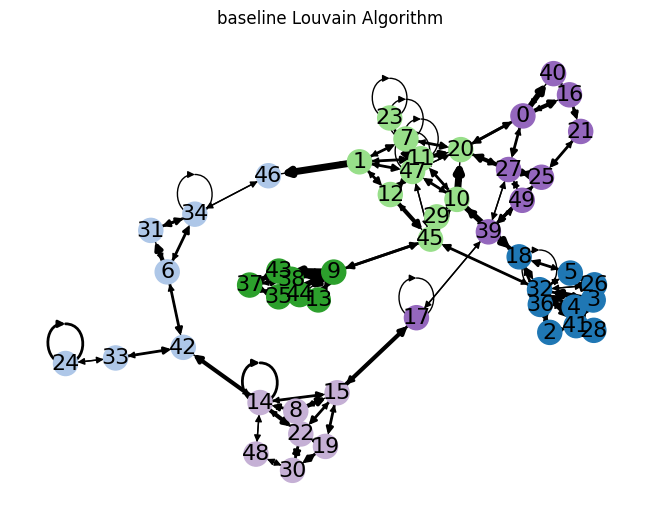

In [ ]:
a = [frozenset(c) for c in baseline_louvain_communities]

for node in a:
    if node not in color_dict:
        color_dict[node] = 0

for i,key in enumerate(color_dict.keys()):
    color_dict[key] = plt.colormaps["tab20"](i)



edge_widths = [edge_attrs[key]["weigth"] for key in edge_attrs.keys()]

n2c_baseline = node_to_com(G, baseline_louvain_communities)

node_colors = [color_dict[frozenset(community)] for node, community in n2c_baseline.items()]
node_colors_baseline = preprocessed_communities_labels

nx.draw(G, with_labels=True, node_color=node_colors, node_size=300, font_size=16, width=edge_widths, arrows=True)
plt.title("baseline Louvain Algorithm")


In [ ]:
mod_dict = defaultdict(list)
for alpha in tqdm.tqdm(np.arange(0,1,0.1)):
    modularities = []
    for ind,I in enumerate(flow_networks):
        F = alpha*I + (1-alpha)*net_adj[ind]
        F = nx.from_numpy_array(F)
        h = ig.Graph.from_networkx(G)

        partition = leidenalg.find_partition(h, leidenalg.ModularityVertexPartition)
        communities = [[] for _ in range(len(partition))]
        # Fill the communities with vertex indices
        for vertex, community in enumerate(partition.membership):
            communities[community].append(vertex)

        ic = communities
        mod_ic = nx.community.modularity(F,ic)
        mod_dict[alpha].append(mod_ic)

100%|██████████| 10/10 [00:00<00:00, 91.74it/s]


In [ ]:
averages = [np.average(values) for  values in mod_dict.values()]
list(mod_dict.keys())[averages.index(max(averages))]
averages

[0.1655045267425263,
 0.16544314372972532,
 0.16536648577598548,
 0.16526804097808417,
 0.16513698283184503,
 0.16495388739605704,
 0.16468008521208105,
 0.16422597707771103,
 0.1633260272930519,
 0.16069052920604682]

In [ ]:
from networkx.generators.community import LFR_benchmark_graph
n = 250
tau1 = 3
tau2 = 1.5
mu = 0.5
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=10, min_community=20, max_community=50
)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import sklearn as sk

In [28]:
a = [1,2,3,0,1,0,1] #[0,1,0,1,0,1,0]
b = [1,1,1,1,0,0,0]

sk.metrics.cluster.normalized_mutual_info_score(a, b), total_kappa(a,b)


(0.21640867668068342, 0.35947712418300654)